## Crime Calculus

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


## Create Spark Session

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

In [ ]:
# Record the start time
start_time = time.time()

In [4]:
# Create a SparkSession
#spark = spark = SparkSession.builder.appName("DataCleaning").getOrCreate()
# Create a SparkSession with appropriate configurations
# Create a SparkSession
spark = SparkSession.builder.appName("ReadFromHadoop").config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000").config("spark.hadoop.rpc.message.max", "52428800").getOrCreate()


#HDFS paths for the files
hdfs_file_path_crime_data = "hdfs://192.168.1.239:9001/input/NYPD_Complaint_Data_Historic_20231117.csv"
hdfs_file_path_shooting_data = "hdfs://192.168.1.239:9001/input/NYPD_Shooting_Incident_Data__Historic__till_2022.csv"

# Read the CSV files from HDFS into PySpark DataFrames
df1 = spark.read.csv(hdfs_file_path_crime_data, header=True, inferSchema=True)
df2 = spark.read.csv(hdfs_file_path_shooting_data, header=True, inferSchema=True)

df1.head()
df2.head()

Row(INCIDENT_KEY=228798151, OCCUR_DATE='05/27/2021', OCCUR_TIME=datetime.datetime(2023, 12, 8, 21, 30), BORO='QUEENS', LOC_OF_OCCUR_DESC=None, PRECINCT=105, JURISDICTION_CODE=0, LOC_CLASSFCTN_DESC=None, LOCATION_DESC=None, STATISTICAL_MURDER_FLAG=False, PERP_AGE_GROUP=None, PERP_SEX=None, PERP_RACE=None, VIC_AGE_GROUP='18-24', VIC_SEX='M', VIC_RACE='BLACK', X_COORD_CD=1058925.0, Y_COORD_CD=180924.0, Latitude=40.662964620000025, Longitude=-73.73083868899994, Lon_Lat='POINT (-73.73083868899994 40.662964620000025)')

In [ ]:
# Test time taken to read data from HDFS for comparison across different partition and block size
# Record the end time
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time} seconds")

## Data Cleaning

In [5]:
# Rename the names of the columns in df2 so that we can merge it with df1
df2 = df2.withColumnRenamed("OCCUR_DATE", "RPT_DT") \
.withColumnRenamed("OCCUR_TIME", "CMPLNT_FR_TM") \
.withColumnRenamed("BORO", "BORO_NM") \
.withColumnRenamed("INCIDENT_KEY", "CMPLNT_NUM") \

# Show the DataFrame to verify the changes
df2.show(5)

+----------+----------+-------------------+-------+-----------------+--------+-----------------+------------------+-------------+-----------------------+--------------+--------+---------+-------------+-------+--------------+------------+-------------+------------------+------------------+--------------------+
|CMPLNT_NUM|    RPT_DT|       CMPLNT_FR_TM|BORO_NM|LOC_OF_OCCUR_DESC|PRECINCT|JURISDICTION_CODE|LOC_CLASSFCTN_DESC|LOCATION_DESC|STATISTICAL_MURDER_FLAG|PERP_AGE_GROUP|PERP_SEX|PERP_RACE|VIC_AGE_GROUP|VIC_SEX|      VIC_RACE|  X_COORD_CD|   Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+----------+-------------------+-------+-----------------+--------+-----------------+------------------+-------------+-----------------------+--------------+--------+---------+-------------+-------+--------------+------------+-------------+------------------+------------------+--------------------+
| 228798151|05/27/2021|2023-12-08 21:30:00| QUEENS|             NUL

In [6]:
# Drop the columns that are not relevant to the analysis(feature selection)
df2 = df2.drop('LOC_OF_OCCUR_DESC','PRECINCT','JURISDICTION_CODE','LOC_CLASSFCTN_DESC','LOCATION_DESC','STATISTICAL_MURDER_FLAG','PERP_AGE_GROUP','PERP_SEX','PERP_RACE','Lon_Lat','VIC_RACE')
df2.show()

+----------+----------+-------------------+---------+-------------+-------+------------+-------------+------------------+------------------+
|CMPLNT_NUM|    RPT_DT|       CMPLNT_FR_TM|  BORO_NM|VIC_AGE_GROUP|VIC_SEX|  X_COORD_CD|   Y_COORD_CD|          Latitude|         Longitude|
+----------+----------+-------------------+---------+-------------+-------+------------+-------------+------------------+------------------+
| 228798151|05/27/2021|2023-12-08 21:30:00|   QUEENS|        18-24|      M|   1058925.0|     180924.0|40.662964620000025|-73.73083868899994|
| 137471050|06/27/2014|2023-12-08 17:40:00|    BRONX|        18-24|      M|   1005028.0|     234516.0| 40.81035186300005|-73.92494232599995|
| 147998800|11/21/2015|2023-12-08 03:56:00|   QUEENS|        25-44|      M|1007667.9375| 209836.53125| 40.74260663300004|-73.91549174199997|
| 146837977|10/09/2015|2023-12-08 18:30:00|    BRONX|          <18|      M| 1006537.375|244511.140625| 40.83778200300003|-73.91945661499994|
|  58921844|0

In [7]:
# Find common columns between both dataframes

# Get column names for each DataFrame
columns_df1 = set(df1.columns)
columns_df2 = set(df2.columns)

# Find common columns between both DataFrames as all columns need to be the same to merge them
common_columns = columns_df1.intersection(columns_df2)

# Display common columns
print("Common columns in both DataFrames:")
print(common_columns)

Common columns in both DataFrames:
{'Y_COORD_CD', 'CMPLNT_FR_TM', 'X_COORD_CD', 'BORO_NM', 'VIC_SEX', 'RPT_DT', 'CMPLNT_NUM', 'VIC_AGE_GROUP', 'Latitude', 'Longitude'}


In [8]:
# Importing the 'lit' function from the 'pyspark.sql.functions' module.
# 'lit' is used to create a literal column expression with a constant value, which can be added to Spark DataFrame.
from pyspark.sql.functions import lit

# Introduce a static column 'OFNS_DESC' in df2 with a constant value 'SHOOTING'.
# This column signifies the type of crime in df1 and is not present in df2. 
# By adding this column with the value 'SHOOTING', we facilitate the identification of shooting crimes in the merged dataset.
df2 = df2.withColumn('OFNS_DESC', lit('SHOOTING'))

# Show the resulting DataFrame
df2.show()

+----------+----------+-------------------+---------+-------------+-------+------------+-------------+------------------+------------------+---------+
|CMPLNT_NUM|    RPT_DT|       CMPLNT_FR_TM|  BORO_NM|VIC_AGE_GROUP|VIC_SEX|  X_COORD_CD|   Y_COORD_CD|          Latitude|         Longitude|OFNS_DESC|
+----------+----------+-------------------+---------+-------------+-------+------------+-------------+------------------+------------------+---------+
| 228798151|05/27/2021|2023-12-08 21:30:00|   QUEENS|        18-24|      M|   1058925.0|     180924.0|40.662964620000025|-73.73083868899994| SHOOTING|
| 137471050|06/27/2014|2023-12-08 17:40:00|    BRONX|        18-24|      M|   1005028.0|     234516.0| 40.81035186300005|-73.92494232599995| SHOOTING|
| 147998800|11/21/2015|2023-12-08 03:56:00|   QUEENS|        25-44|      M|1007667.9375| 209836.53125| 40.74260663300004|-73.91549174199997| SHOOTING|
| 146837977|10/09/2015|2023-12-08 18:30:00|    BRONX|          <18|      M| 1006537.375|244511

In [9]:
# Cleaning DF1

from pyspark.sql.functions import to_timestamp

columns_to_drop_na = ['Y_COORD_CD', 'X_COORD_CD', 'Latitude', 'Longitude', 'CMPLNT_FR_TM','Lat_Lon', 'CMPLNT_FR_DT', 'BORO_NM', 'OFNS_DESC']
for column in columns_to_drop_na:
    df1 = df1.filter(col(column).isNotNull())

# Dropping columns that are not significant for future data exploration
columns_to_drop = ['PARKS_NM','STATION_NAME','TRANSIT_DISTRICT','HADEVELOPT','HOUSING_PSA','VIC_RACE', 'LOC_OF_OCCUR_DESC', 'Lat_Lon',
                  'PREM_TYP_DESC','SUSP_AGE_GROUP','SUSP_SEX','SUSP_RACE','JURISDICTION_CODE', 'ADDR_PCT_CD',
                   'PD_CD','PD_DESC','PATROL_BORO','CMPLNT_TO_DT','CMPLNT_TO_TM','KY_CD','LAW_CAT_CD','CMPLNT_FR_DT','JURIS_DESC','CRM_ATPT_CPTD_CD']

df1 = df1.drop(*columns_to_drop)

# Replacing NaN values in specific columns with 'UNKNOWN'
columns_to_fill = ['VIC_AGE_GROUP', 'VIC_SEX']
for column in columns_to_fill:
    df1 = df1.withColumn(column, when(col(column).isNull(), 'UNKNOWN').otherwise(col(column)))

# Remove rows in the dataset where values are either null or the string "(null)".
specified_value = '(null)'
# Filter the DataFrame to exclude rows with the specified value
df1 = df1.filter(df1['BORO_NM'] != specified_value)
df1 = df1.filter(df1['CMPLNT_FR_TM'] != specified_value)
df1 = df1.filter(df1['VIC_AGE_GROUP'] != specified_value)
df1 = df1.filter(df1['OFNS_DESC'] != specified_value)


# Convert Complaint_Time Column from String to timestamp format
df1 = df1.withColumn('CMPLNT_FR_TM', to_timestamp('CMPLNT_FR_TM', 'HH:mm:ss'))

# Examining the changes
df1.printSchema()
df1.show()

root
 |-- CMPLNT_NUM: string (nullable = true)
 |-- CMPLNT_FR_TM: timestamp (nullable = true)
 |-- RPT_DT: string (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- X_COORD_CD: integer (nullable = true)
 |-- Y_COORD_CD: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- VIC_AGE_GROUP: string (nullable = true)
 |-- VIC_SEX: string (nullable = true)

+----------+-------------------+----------+--------------------+-------------+----------+----------+----------------+-----------------+-------------+-------+
|CMPLNT_NUM|       CMPLNT_FR_TM|    RPT_DT|           OFNS_DESC|      BORO_NM|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|VIC_AGE_GROUP|VIC_SEX|
+----------+-------------------+----------+--------------------+-------------+----------+----------+----------------+-----------------+-------------+-------+
|  10361314|1970-01-01 16:35:00|02/11/2006|ASSAULT 3 & RELAT..

In [10]:
# DF2 data cleaning

from pyspark.sql.functions import date_format

# Remove null values from DF2
columns_to_drop_na = ['Y_COORD_CD', 'X_COORD_CD', 'Latitude', 'Longitude', 'CMPLNT_FR_TM','VIC_AGE_GROUP', 'RPT_DT', 'BORO_NM', 'OFNS_DESC', 'VIC_SEX']
for column in columns_to_drop_na:
    df1 = df1.filter(col(column).isNotNull())

# Rearrange the columns in df2 to align with the order in df1. 
# This step is crucial for a proper merging of these dataframes.
columns_df1 = df1.columns
df2 = df2.select(columns_df1)
df2.show()

+----------+-------------------+----------+---------+---------+------------+-------------+------------------+------------------+-------------+-------+
|CMPLNT_NUM|       CMPLNT_FR_TM|    RPT_DT|OFNS_DESC|  BORO_NM|  X_COORD_CD|   Y_COORD_CD|          Latitude|         Longitude|VIC_AGE_GROUP|VIC_SEX|
+----------+-------------------+----------+---------+---------+------------+-------------+------------------+------------------+-------------+-------+
| 228798151|2023-12-08 21:30:00|05/27/2021| SHOOTING|   QUEENS|   1058925.0|     180924.0|40.662964620000025|-73.73083868899994|        18-24|      M|
| 137471050|2023-12-08 17:40:00|06/27/2014| SHOOTING|    BRONX|   1005028.0|     234516.0| 40.81035186300005|-73.92494232599995|        18-24|      M|
| 147998800|2023-12-08 03:56:00|11/21/2015| SHOOTING|   QUEENS|1007667.9375| 209836.53125| 40.74260663300004|-73.91549174199997|        25-44|      M|
| 146837977|2023-12-08 18:30:00|10/09/2015| SHOOTING|    BRONX| 1006537.375|244511.140625| 40.

In [11]:
# Check if the 'OFNS_DESC' column is present in both dataframes, confirming its addition to DF2.
# Additionally, ensure that no essential columns were inadvertently dropped during the data cleaning process.

# Get column names for each DataFrame
columns_df1 = set(df1.columns)
columns_df2 = set(df2.columns)

# Find common columns between both DataFrames
common_columns = columns_df1.intersection(columns_df2)

# Display common columns
print("Common columns in both DataFrames:")
print(common_columns)

Common columns in both DataFrames:
{'Y_COORD_CD', 'CMPLNT_FR_TM', 'X_COORD_CD', 'BORO_NM', 'VIC_SEX', 'RPT_DT', 'OFNS_DESC', 'CMPLNT_NUM', 'Longitude', 'Latitude', 'VIC_AGE_GROUP'}


## Dataset Merging

In [12]:
# Merging both dataframes
df = df1.union(df2);

df.show()

+----------+-------------------+----------+--------------------+-------------+----------+----------+----------------+-----------------+-------------+-------+
|CMPLNT_NUM|       CMPLNT_FR_TM|    RPT_DT|           OFNS_DESC|      BORO_NM|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|VIC_AGE_GROUP|VIC_SEX|
+----------+-------------------+----------+--------------------+-------------+----------+----------+----------------+-----------------+-------------+-------+
|  10361314|1970-01-01 16:35:00|02/11/2006|ASSAULT 3 & RELAT...|     BROOKLYN|  999496.0|  190300.0|  40.68900139556|-73.9450265328727|        45-64|      F|
|  10363948|1970-01-01 17:15:00|02/11/2006|       HARRASSMENT 2|     BROOKLYN| 1007052.0|  193757.0|40.6984738177025| -73.917768981221|        18-24|      F|
|  16719307|1970-01-01 00:01:00|06/08/2006|                RAPE|        BRONX| 1017478.0|  256069.0|40.8694704770483|-73.8798608037303|          <18|      F|
|  16939015|1970-01-01 19:00:00|06/29/2006|         

## Cleaning combined dataset

In [13]:
# Check number of duplicate rows

# Total number of rows in the DataFrame
total_rows = df.count()

# Count the number of unique rows
unique_rows = df.distinct().count()

duplicate_rows = total_rows - unique_rows

print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 3756


In [14]:
# Remove duplicate rows
df = df.distinct()

In [15]:
# Confirm removal of duplicate rows
# Show count of total number of rows

# Total number of rows in the DataFrame
total_rows = df.count()

# Count the number of unique rows
unique_rows = df.distinct().count()

duplicate_rows = total_rows - unique_rows

print(f"Number of duplicate rows: {duplicate_rows}")
print(f"Total number of rows: {total_rows}")

Number of duplicate rows: 0
Total number of rows: 6740457


In [16]:
# Rename crime for better viewing during visualiation

df = df.withColumn("OFNS_DESC", when(df["OFNS_DESC"] == "HARRASSMENT 2", "HARRASSMENT").otherwise(df["OFNS_DESC"]))
df = df.withColumn("OFNS_DESC", when(df["OFNS_DESC"] == "ASSAULT 3 & RELATED OFFENSES", "ASSAULT").otherwise(df["OFNS_DESC"]))

In [17]:
# Set 'UNKNOWN' for victim_sex if it's not 'F' or 'M' due to incomplete data.
df = df.withColumn('VIC_SEX', when((col('VIC_SEX') != 'M') & (col('VIC_SEX') != 'F'), 'UNKNOWN').otherwise(col('VIC_SEX')))

## Data Analysis & Visualization

In [18]:
# Show the top 10 types of crime

top_10_crime_types = df.groupBy("OFNS_DESC").count().orderBy(col("count").desc()).limit(10)

# Show the top 10 crime types
top_10_crime_types.show(10)

+--------------------+-------+
|           OFNS_DESC|  count|
+--------------------+-------+
|       PETIT LARCENY|1129048|
|         HARRASSMENT|1065198|
|             ASSAULT| 847359|
|       GRAND LARCENY| 661511|
|CRIMINAL MISCHIEF...| 654121|
|OFF. AGNST PUB OR...| 396573|
|      FELONY ASSAULT| 314684|
|             ROBBERY| 275542|
|            BURGLARY| 227149|
|MISCELLANEOUS PEN...| 171694|
+--------------------+-------+



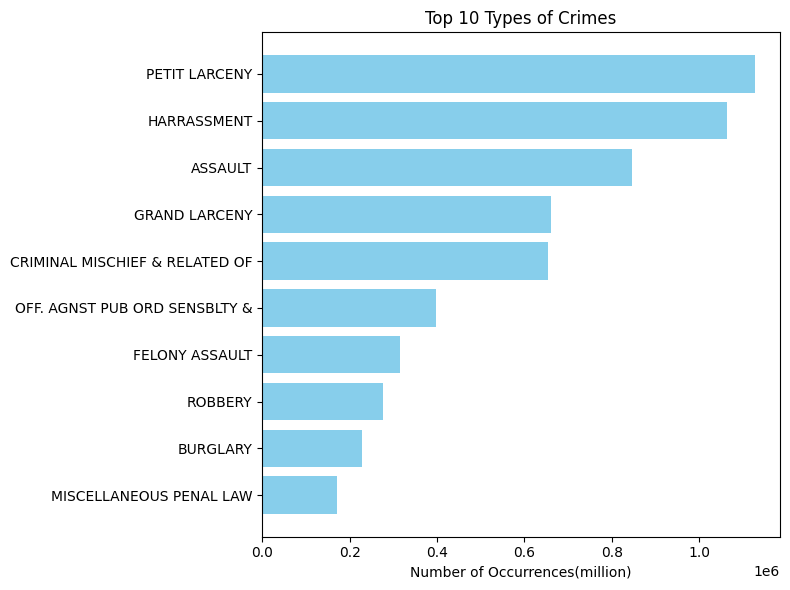

In [19]:
# Get the top 10 types of crimes

import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Get the top 10 types of crimes
top_10_crime_types = df.groupBy("OFNS_DESC").count().orderBy("count", ascending=False).limit(10)

# Collect the data to the local machine (driver) for visualization
crime_types_list = [row.OFNS_DESC for row in top_10_crime_types.collect()]
crime_counts_list = [row['count'] for row in top_10_crime_types.collect()]

# Plotting using Matplotlib
plt.figure(figsize=(8, 6))
plt.barh(crime_types_list, crime_counts_list, color='skyblue')
plt.xlabel('Number of Occurrences(million)')
plt.title('Top 10 Types of Crimes')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.tight_layout()
plt.show()

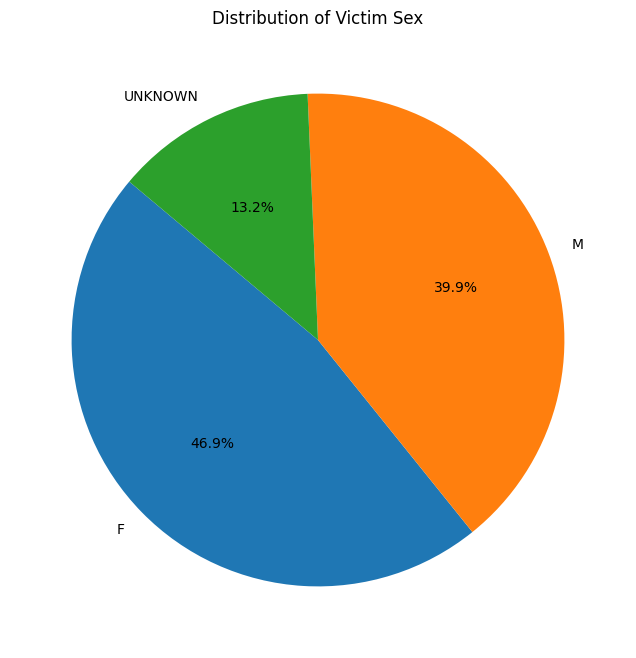

In [20]:
# Distribution of Victim Sex

# Group by 'VIC_SEX' and count occurrences of each sex
sex_distribution = df.groupBy('VIC_SEX').count()

# Convert PySpark DataFrame to Pandas DataFrame for plotting
sex_distribution_pandas = sex_distribution.toPandas()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sex_distribution_pandas['count'], labels=sex_distribution_pandas['VIC_SEX'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Victim Sex')
plt.show()

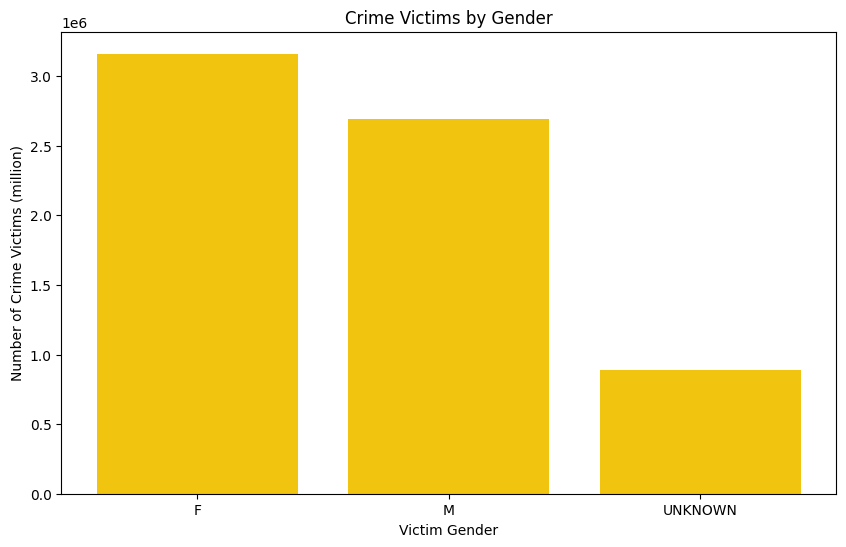

+-------+------------------+
|VIC_SEX|        percentage|
+-------+------------------+
|      F|46.889179769264906|
|      M|  39.8956480250523|
|UNKNOWN| 13.21517220568279|
+-------+------------------+



In [21]:
# Count of Crime Victims By Gender

# Group by 'VIC_SEX' and count occurrences of each sex
sex_distribution = df.groupBy('VIC_SEX').count()

# Order by count in descending order and select the top 3
top_3_sex = sex_distribution.orderBy(F.desc('count')).limit(3)

# Convert PySpark DataFrame to Pandas DataFrame for plotting
top_3_sex_pandas = top_3_sex.toPandas()

# Plotting the bar graph with explicit tick labels
plt.figure(figsize=(10, 6))
plt.bar(top_3_sex_pandas.index, top_3_sex_pandas['count'], color='#F1C40F')
plt.xlabel('Victim Gender')
plt.ylabel('Number of Crime Victims (million)')
plt.title('Crime Victims by Gender')
plt.xticks(top_3_sex_pandas.index, top_3_sex_pandas['VIC_SEX'], rotation=0)
plt.show()

# Calculate victims by gender percentage
total_records = df.count()
vic_sex_per = (sex_distribution
               .withColumn('percentage', F.col('count') / total_records * 100)
               .select('VIC_SEX', 'percentage'))
vic_sex_per.show()

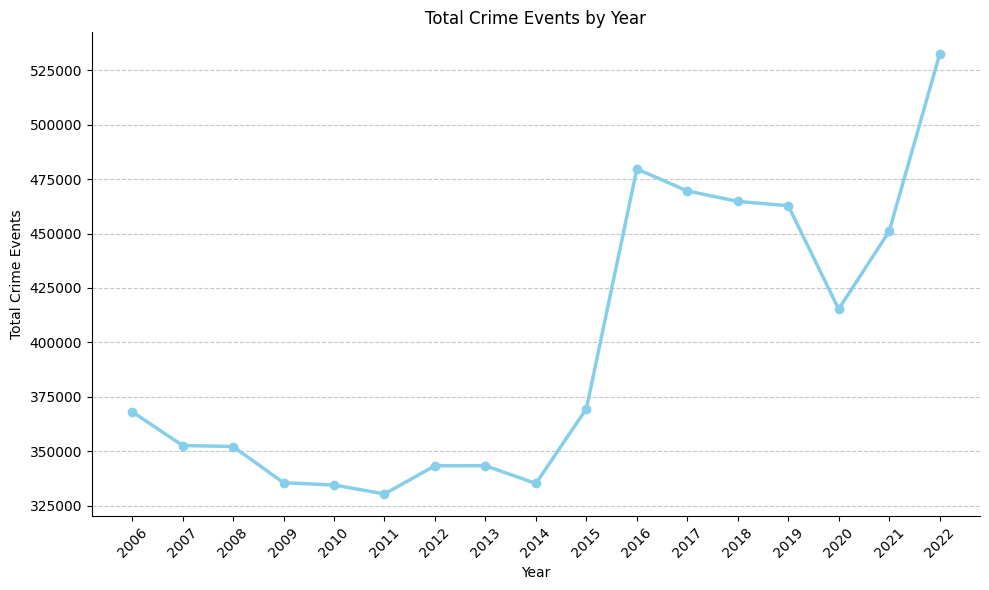

In [22]:
# Crime Events By Year

# Extract year from 'RPT_DT' column as a string
df = df.withColumn('year', F.substring(df['RPT_DT'], -4, 4))

# Group by 'year' and count occurrences of each year
crime_events_by_year = df.groupBy('year').count().orderBy('year')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
crime_events_pandas = crime_events_by_year.toPandas()

# Create a fancy line plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(crime_events_pandas['year'], crime_events_pandas['count'], marker='o', color='skyblue', linewidth=2.5)
plt.xlabel('Year')
plt.ylabel('Total Crime Events')
plt.title('Total Crime Events by Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Customize grid and background
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

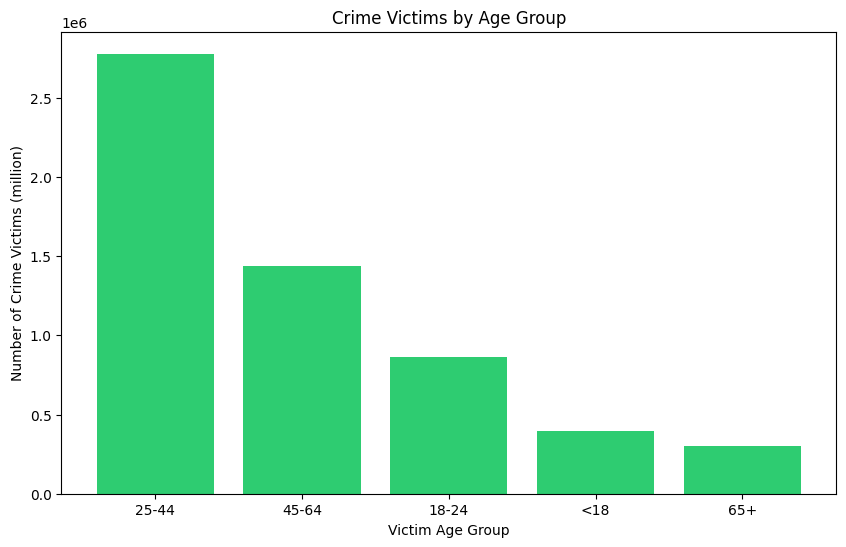

+-------------+------------------+
|VIC_AGE_GROUP|        percentage|
+-------------+------------------+
|        25-44| 41.21876306013079|
|        45-64|21.315913742940577|
|        18-24|12.802351531951023|
|          <18| 5.891366119537592|
|          65+| 4.445054689911975|
+-------------+------------------+



In [23]:
# Crime Victims By Age Group

# Group by 'VIC_AGE_GROUP' and count occurrences of each age group
age_group_distribution = df.groupBy('VIC_AGE_GROUP').count()

# Select specific age groups based on iloc[[0, 1, 2, 4, 5]]
selected_age_groups = age_group_distribution.filter(F.col('VIC_AGE_GROUP').isin(['<18', '18-24', '25-44', '45-64', '65+']))

# Order by count in descending order
selected_age_groups = selected_age_groups.orderBy(F.desc('count'))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
selected_age_groups_pandas = selected_age_groups.toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(selected_age_groups_pandas['VIC_AGE_GROUP'], selected_age_groups_pandas['count'], color='#2ECC71')
plt.xlabel('Victim Age Group')
plt.ylabel('Number of Crime Victims (million)')
plt.title('Crime Victims by Age Group')
plt.xticks(rotation=0)
plt.show()

# Calculate victims by age group percentage
total_records = df.count()
vic_age_per = (selected_age_groups
               .withColumn('percentage', F.col('count') / total_records * 100)
               .select('VIC_AGE_GROUP', 'percentage'))
vic_age_per.show()

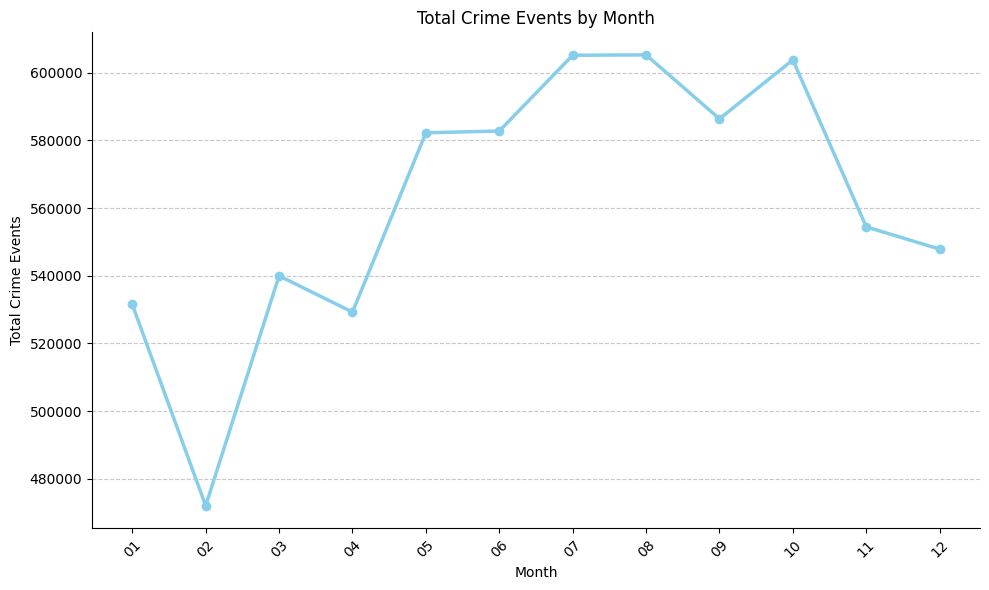

In [24]:
# Crime Events by Month

# Extract year from 'RPT_DT' column as a string
df_month = df.withColumn('Month', F.substring(df['RPT_DT'], 1, 2))

# Group by 'year' and count occurrences of each year
crime_events_by_year = df_month.groupBy('Month').count().orderBy('Month')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
crime_events_pandas = crime_events_by_year.toPandas()

# Create a fancy line plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(crime_events_pandas['Month'], crime_events_pandas['count'], marker='o', color='skyblue', linewidth=2.5)
plt.xlabel('Month')
plt.ylabel('Total Crime Events')
plt.title('Total Crime Events by Month')
plt.xticks(rotation=45)
plt.tight_layout()

# Customize grid and background
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

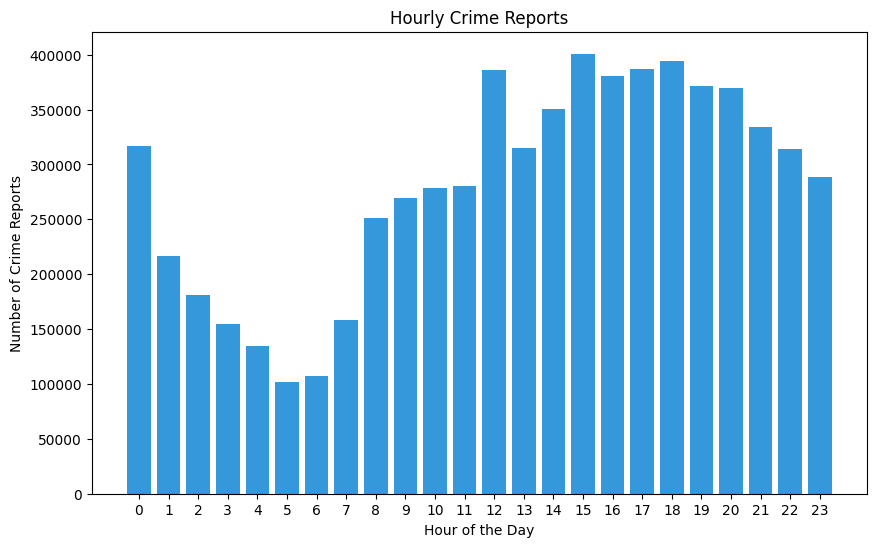

In [25]:
# Crime Reports based on hour of the day

# Extract hour from the timestamp column
crime_data = df.withColumn('hour', F.hour('CMPLNT_FR_TM'))

# Group by 'hour' and count occurrences of each hour
crime_reports_by_hour = crime_data.groupBy('hour').count().orderBy('hour')

# Convert PySpark DataFrame to Pandas DataFrame for plotting
crime_reports_pandas = crime_reports_by_hour.toPandas()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(crime_reports_pandas['hour'], crime_reports_pandas['count'], color='#3498DB')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crime Reports')
plt.title('Hourly Crime Reports')
plt.xticks(range(24)) 
plt.xticks(rotation=0)
plt.show()

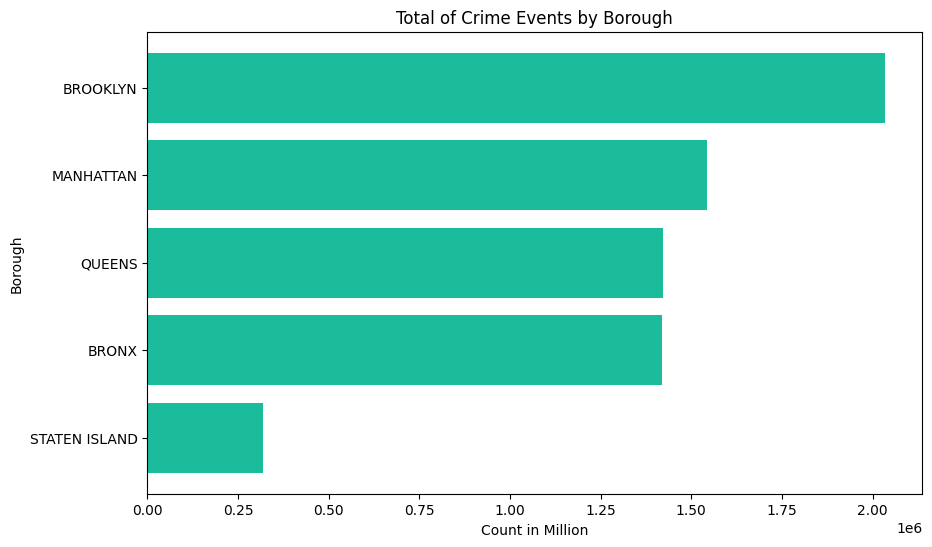

In [26]:
# Crime events in each borough

# Count the occurrences of each value in 'BORO_NM' and sort
borough_counts = df.groupBy("BORO_NM").count().orderBy("count")

# Convert to Pandas DataFrame for plotting
borough_counts_pd = borough_counts.toPandas()

# Plot using Matplotlib
plt.figure(figsize=(10,6))
plt.barh(borough_counts_pd['BORO_NM'], borough_counts_pd['count'], color='#1ABC9C')
plt.title('Total of Crime Events by Borough')
plt.xlabel('Count in Million')
plt.ylabel('Borough')
plt.show()